##  Data Analytics in Network Biology

*Ferdinando Giordano* <br> *Lorenzo Mainetti* <br> *Group 269701*

*** 



__Project Oveview__: During the in class presentation illustrated by A.Z. Senior Data Scientist we have been furtherly informed about __network biology__, exploring in detail the applications of this discipline in the realm of drug discovery, diagnosis assistance, biological predictions, and other valuable applications. Furthermore, in the project we dealt with the famous __Hetionet__ integrative network (__[hetionet](https://het.io)__). 
The network combines over 50 years of biomedical information into a single resource, consisting of 47,031 nodes (11 types) and 2,250,197 relationships (24 types). We were required to compute different types of metrics and analysis to gain insights from the knowledge graph. In particular, we analysed the similarities between diseases and/or symptoms such as: _type 1 diabetes mellitus_ and _type 2 diabetes mellitus_, _eye pain_ and _blindess_ ,and others. Lastly, we were required to support an imaginary patient that reported one symptom. We Tried to help
them with some data analysis (e.g., study the possible diseases, select the disease, the gene, the possible compounds, the side effects, try to mitigate side effects, and so on...). 









In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import Counter, defaultdict
import numpy as np
import seaborn as sns 
import itertools as it
from sklearn.preprocessing import RobustScaler
import community as community_louvain

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### Task 1: Graph Construction


In [10]:
# Loading the data

edges = '/code_and_data/edges.sif'

nodes = '/code_and_data/hetionet-v1.0-nodes.tsv'

In [11]:
# Graph construction

G = nx.MultiDiGraph()

# process the nodes file to create nodes with attributes
with open(nodes, 'r') as nodes_file:
    next(nodes_file)  # skip the header
    for line in nodes_file:
        parts = line.strip().split('\t')
        node_id, node_name, node_kind = parts
        # create the node with its attributes
        G.add_node(node_id, name=node_name, kind=node_kind)

# process the edges file to add edges
with open(edges, 'r') as edges_file:
    next(edges_file)  # skip the header
    for line in edges_file:
        parts = line.strip().split('\t')
        node1, interaction_type, node2 = parts
        # add the edge to the graph with its interaction type
        G.add_edge(node1, node2, interaction_type=interaction_type)


print("Number of edges:", G.number_of_edges())
print("Sample nodes with attributes:", list(G.nodes(data=True))[:5])


Number of edges: 2250197
Sample nodes with attributes: [('Anatomy::UBERON:0000002', {'name': 'uterine cervix', 'kind': 'Anatomy'}), ('Anatomy::UBERON:0000004', {'name': 'nose', 'kind': 'Anatomy'}), ('Anatomy::UBERON:0000006', {'name': 'islet of Langerhans', 'kind': 'Anatomy'}), ('Anatomy::UBERON:0000007', {'name': 'pituitary gland', 'kind': 'Anatomy'}), ('Anatomy::UBERON:0000010', {'name': 'peripheral nervous system', 'kind': 'Anatomy'})]





#### Task 2: Analyzing the biomedical knowledge graph


 

In [17]:
# Task 2.1: Compute and list the total number of entities for each unique kind 

def count_node_kinds(graph):
    kinds = [data['kind'] for node, data in graph.nodes(data=True)]
    kind_counts = Counter(kinds)
    return kind_counts

kind_counts = count_node_kinds(G)

# Converting the counter to a pandas Series for better formatting
kind_series = pd.Series(kind_counts).sort_values(ascending=False)

print(kind_series)

Gene                   20945
Biological Process     11381
Side Effect             5734
Molecular Function      2884
Pathway                 1822
Compound                1552
Cellular Component      1391
Symptom                  438
Anatomy                  402
Pharmacologic Class      345
Disease                  137
dtype: int64


In [18]:
# Task 2.2: Compute and list the total number of each unique edge type 

def count_edge_types(graph):
    interaction_types = [data['interaction_type'] for _, _, data in graph.edges(data=True)]
    interaction_type_counts = Counter(interaction_types)
    return interaction_type_counts

# Computing interaction types
interaction_type_counts = count_edge_types(G)
interaction_type_series = pd.Series(interaction_type_counts).sort_values(ascending=False)
print(interaction_type_series)

GpBP    559504
AeG     526407
Gr>G    265672
GiG     147164
CcSE    138944
AdG     102240
AuG      97848
GpMF     97222
GpPW     84372
GpCC     73566
GcG      61690
CdG      21102
CuG      18756
DaG      12623
CbG      11571
DuG       7731
DdG       7623
CrC       6486
DlA       3602
DpS       3357
PCiC      1029
CtD        755
DrD        543
CpD        390
dtype: int64


In [19]:
#ONE-FOR-ALL (All Might)
# collect comprehensive degree data for each node type and compile specific node lists

def OneForAll(graph):
    # initialize dictionaries to hold total degrees for each node type
    total_in_degrees = defaultdict(int)
    total_out_degrees = defaultdict(int)
    # initialize lists to store diseases and symptom
    disease_nodes = []
    symptom_nodes = []
    diseases_degree = {} # initialize dictionary to store in-degree, out-degree and total degree for each disease
    
    # iterate over all nodes to aggregate in-degree and out-degree by kind
    for node, data in graph.nodes(data=True):
        node_type = data['kind']
        in_degree = graph.in_degree(node)
        out_degree = graph.out_degree(node)
        total_in_degrees[node_type] += in_degree
        total_out_degrees[node_type] += out_degree
        # update disease and symptom lists 
        if node_type == 'Disease':
            disease_nodes.append(node)
            diseases_degree[node] = [data['name'], in_degree, out_degree, in_degree + out_degree] # compute in and out degree for each disease
        elif node_type == 'Symptom':
            symptom_nodes.append(node)

    return total_in_degrees, total_out_degrees, disease_nodes, symptom_nodes, diseases_degree

total_in_degrees, total_out_degrees, disease_nodes, symptom_nodes, diseases_degree = OneForAll(G)

In [20]:
# Task 2.3: Compute the average in-degree and out-degree, for each type of node.

def average_degree_by_kind(graph, total_degrees, kind_counts): # Computing the average in-degree by kind
    
    average_degrees = {node_type: total_degrees[node_type] / kind_counts[node_type] for node_type in kind_counts}
    
    return average_degrees

In [22]:
# compute the average in-degree by kind

average_in_degrees = average_degree_by_kind(G, total_in_degrees, kind_counts)

# creating and sorting the DataFrame
sorted_avg_in_degrees = (
    pd.DataFrame.from_dict(average_in_degrees, orient='index', columns=['In-Degree'])
    .sort_values(by='In-Degree', ascending=False)
    .reset_index()
    .rename(columns={'index': 'Kind'})
)

# displaying the results with styled bar
styled_result = sorted_avg_in_degrees.style.bar(subset=['In-Degree'], color='#d65f5f').set_caption('<b>Average In-Degree by Kind</b>')
styled_result

,Kind,In-Degree
0,Gene,61.132824
1,Cellular Component,52.887132
2,Biological Process,49.161234
3,Pathway,46.307355
4,Molecular Function,33.710818
5,Side Effect,24.231601
6,Disease,12.321168
7,Anatomy,8.960199
8,Symptom,7.664384
9,Compound,4.842139


>Gene being the central section of the knowledge network, reasonably demonstrates the highest in-degree 

In [23]:
# compute the average out-degree by kind

average_out_degrees = average_degree_by_kind(G, total_out_degrees, kind_counts)

# creating and sorting the DataFrame
sorted_avg_out_degrees = (
    pd.DataFrame.from_dict(average_out_degrees, orient='index', columns=['Out-Degree'])
    .sort_values(by='Out-Degree', ascending=False)
    .reset_index()
    .rename(columns={'index': 'Kind'})
)

# displaying the results with styled bar
styled_result = sorted_avg_out_degrees.style.bar(subset=['Out-Degree'], color='#808080').set_caption('<b>Average Out-Degree by Kind</b>')  
styled_result

,Kind,Out-Degree
0,Anatomy,1807.201493
1,Disease,258.970803
2,Compound,127.579897
3,Gene,61.551206
4,Pharmacologic Class,2.982609
5,Biological Process,0.000000
6,Cellular Component,0.000000
7,Molecular Function,0.000000
8,Pathway,0.000000
9,Side Effect,0.000000


> Anatomy reports the highest out-degree since it upregulates, expresses and downregulate Gene 

### Disease analysis 
In this section we will try to define how frequent and connected a disease is. Further, we are interested in discovering the relationships with its symptoms.  


In [24]:
# Disease analysis -1 For each “Disease” compute the number of connections (in-degree and out-degree) and show the most connected diseases.

# creating and sorting the DataFrame

sorted_diseases_degree = (
    pd.DataFrame.from_dict(diseases_degree, orient='index', columns=['Name', 'In_Degree', 'Out-Degree', 'Total Degree'])
    .sort_values(by='Total Degree', ascending=False)
    .reset_index()
    .rename(columns={'index': 'Disease ID'})
)

top_5_diseases = sorted_diseases_degree.head(5)

# setting a title and displaying the DataFrame
print('Top 5 most connected diseases and their connection counts:')
print(top_5_diseases.to_string(index=False))

Top 5 most connected diseases and their connection counts:
        Disease ID                   Name  In_Degree  Out-Degree  Total Degree
Disease::DOID:1612          breast cancer         44        1115          1159
Disease::DOID:2531     hematologic cancer         53        1076          1129
Disease::DOID:2986 IgA glomerulonephritis          0         966           966
Disease::DOID:1909               melanoma         13         931           944
Disease::DOID:7148   rheumatoid arthritis         38         868           906


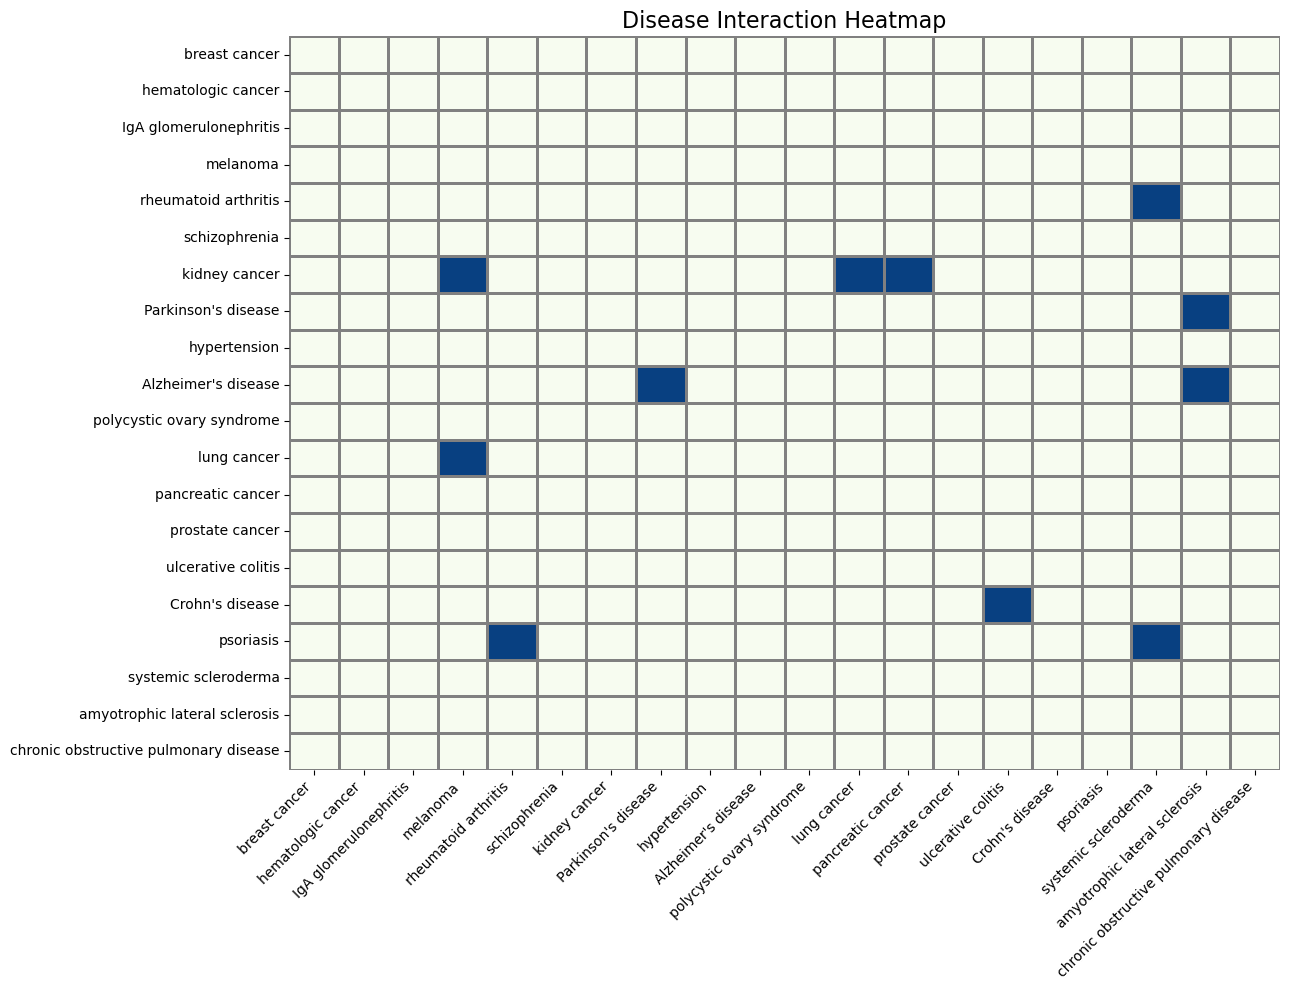

In [31]:
# Disease interaction heatmap

def disease_interaction_heatmap(graph, disease_data):
    # Create a matrix for the heatmap
    indices = disease_data['Disease ID']
    names = disease_data['Name'].values  
    matrix = pd.DataFrame(0, index=names, columns=names) 
    for i, n1 in enumerate(indices):
        for j, n2 in enumerate(indices):
            if graph.has_edge(n1, n2):
                matrix.iloc[i, j] = 1  

    # Creating the heatmap
    plt.figure(figsize=(13, 10))
    sns.heatmap(matrix, cmap="GnBu", annot=False, cbar=False, 
                linewidths=1, linecolor='grey', fmt='d')
    plt.title("Disease Interaction Heatmap", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)  
    plt.tight_layout() 
    plt.show()

    # plt.savefig("networkplots/disease_interaction_heatmap.png", dpi=300)  # Saving with high res
    plt.close()  

disease_interaction_heatmap(G, sorted_diseases_degree.head(20))

> It can be seen that the 'Disease Interaction Heatmap' illustrates reasonable interactions, as for example: _Parkinson's disease_ and _Alzheimer's_ 

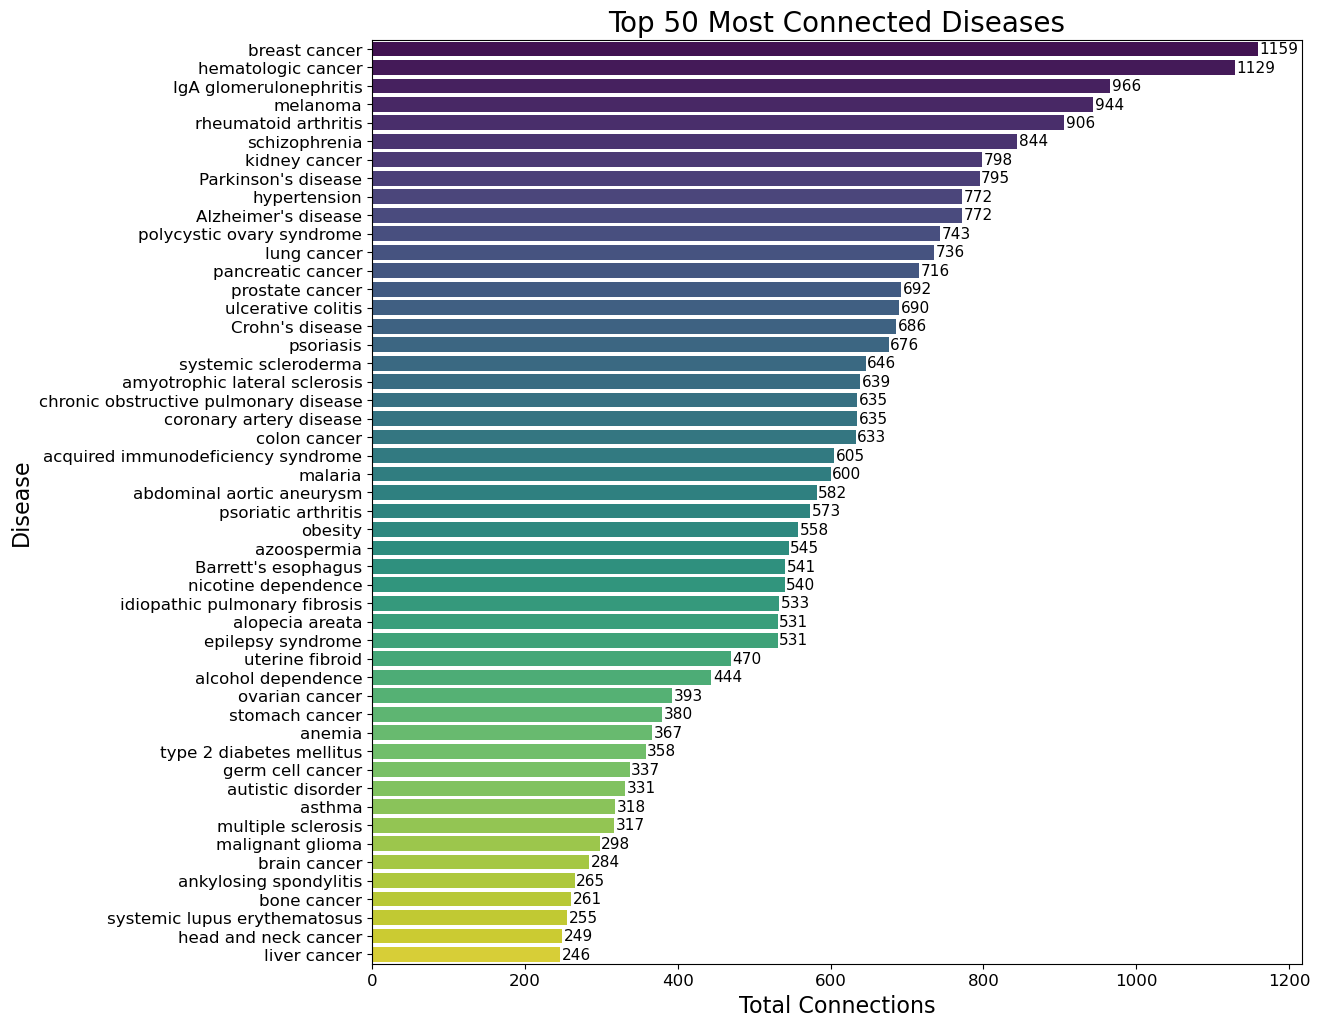

In [26]:
# Top 50 most connected diseases

top_diseases = sorted_diseases_degree.head(50)

plt.figure(figsize=(12, 12))
bar = sns.barplot(x='Total Degree', y='Name', data=top_diseases, palette='viridis')
plt.title('Top 50 Most Connected Diseases', fontsize=20)
plt.xlabel('Total Connections', fontsize=16)
plt.ylabel('Disease', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for p in bar.patches:
    width = p.get_width()
    plt.text(width + 2,  
             p.get_y() + p.get_height() / 2,  
             '{:1.0f}'.format(width),  
             ha = 'left',   
             va = 'center', 
             fontsize=11)
plt.show()
# plt.savefig("networkplots/top_diseases.png", dpi=300)  # Saving with high res
plt.close()

In [32]:
# Disease analysis -2 Compute the sub-graph of “Disease” and “Symptom” - Average number of symptoms per disease and average number of diseases per symptom.

# create subgraph and compute average number of connections between a disease and a symptom

subG = G.subgraph(disease_nodes + symptom_nodes)

print(f'Symptoms and Diseases subgraph is a {subG}')

def compute_averages(graph, disease_nodes, symptom_nodes):
    # initialize dictionaries to count symptoms and diseases
    disease_to_symptom_counts = defaultdict(set)
    symptom_to_disease_counts = defaultdict(set)

    # process each symptom for its diseases
    for symptom in symptom_nodes:
        for disease in graph.predecessors(symptom):
            disease_to_symptom_counts[disease].add(symptom)
            symptom_to_disease_counts[symptom].add(disease)

    # calculate averages
    total_symptoms = sum(len(symptoms) for symptoms in disease_to_symptom_counts.values())
    avg_symptoms_per_disease = total_symptoms / len(disease_nodes)

    total_diseases = sum(len(diseases) for diseases in symptom_to_disease_counts.values())
    avg_diseases_per_symptom = total_diseases / len(symptom_nodes)

    return avg_symptoms_per_disease, avg_diseases_per_symptom
    
# compute average number of connections
avg_symptoms_per_disease, avg_diseases_per_symptom = compute_averages(subG, disease_nodes, symptom_nodes)
print(f"Average Number of Symptoms per Disease: {avg_symptoms_per_disease}")
print(f"Average Number of Diseases per Symptom: {avg_diseases_per_symptom}")

Symptoms and Diseases subgraph is a MultiDiGraph with 575 nodes and 3900 edges
Average Number of Symptoms per Disease: 24.503649635036496
Average Number of Diseases per Symptom: 7.664383561643835


##### Computing similarities between Type 1 diabetes mellitus and Type 2 diabetes mellitus 

Some considerations: 

Type 1 diabetes mellitus is an autoimmune disorder where the immune system mistakenly attacks insulin-producing beta cells in the pancreas. This destruction leads to an insulin deficiency, meaning glucose cannot enter cells and remains in the bloodstream, causing high blood sugar. 

Type 2 diabetes mellitus is primarily characterized by insulin resistance, where the body's cells do not respond effectively to insulin, coupled with eventual insulin deficiency. This resistance leads to elevated blood glucose levels as glucose accumulates in the bloodstream instead of being absorbed by cells. Common symptoms include increased thirst, frequent urination, hunger, fatigue, and blurred vision. 


Type 1 and Type 2 diabetes mellitus both involve dysregulation of blood glucose levels due to issues with insulin, a critical hormone for glucose uptake by cells. In Type 1, the body’s immune system destroys insulin-producing cells in the pancreas, leading to insulin deficiency. In Type 2, cells develop insulin resistance, reducing insulin effectiveness, accompanied by a relative insulin deficiency over time. Both types result in high blood sugar (hyperglycemia) which can cause similar chronic complications, including kidney damage, cardiovascular disease, and neuropathy.





We are interested in observing both straightforward similarities (e.g. Common Successors) and some hidden patterns in the graph with the aim of gaining valuable insights (Adamic/Adar Index): 


*Common Successors*: Common successors in a directed graph like Hetionet are insightful because they can reveal shared outcomes, effects, or characteristics between different nodes—in this case, diseases. For type 1 and type 2 diabetes mellitus, common successors such as shared symptoms, impacted genes, or affected anatomical structures can provide valuable insights into the pathophysiological similarities between these diseases


*Adamic/Adar Index*: $AA(u, v) = \sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{\log |\Gamma(w)|}$

In the context of a directed multidigraph, the traditional Adamic/Adar Index, which was originally designed for undirected graphs, has been adapted to consider the directionality of connections. Instead of simply considering all neighbors, we focus specifically on successors (or alternatively, predecessors) of each node. This adjustment ensures that the similarity measure respects the directional nature of the relationships in the graph, which is critical in domains like biology where the direction of influence (e.g., gene activation, metabolic pathways) matters.  

*Multidigraph A/A Index* $AA(u, v) = \sum_{w \in S(u) \cap S(v)} \frac{1}{\log |P(w)|}$

 








In [33]:
# Common Successors shared between Type 1 and Type 2 Diabetes Mellitus

type1_doid = 'Disease::DOID:9744'
type2_doid = 'Disease::DOID:9352'

# Getting sets of successors for each disease
successors_type1 = set(G.successors(type1_doid))
successors_type2 = set(G.successors(type2_doid))

common_successors = successors_type1.intersection(successors_type2)
print("Common Successors:", common_successors)

Common Successors: {'Anatomy::UBERON:0002523', 'Symptom::D011507', 'Gene::169792', 'Gene::952', 'Gene::4842', 'Gene::847', 'Gene::5078', 'Gene::3630', 'Gene::213', 'Gene::1956', 'Gene::3767', 'Symptom::D018589', 'Gene::723961', 'Anatomy::UBERON:0002387', 'Gene::6833', 'Anatomy::UBERON:0002522', 'Anatomy::UBERON:0001530', 'Anatomy::UBERON:0001324', 'Gene::2572', 'Gene::4843', 'Gene::836', 'Gene::6648', 'Gene::1234', 'Anatomy::UBERON:0002386', 'Symptom::D015430', 'Anatomy::UBERON:0001322', 'Anatomy::UBERON:0001323', 'Gene::4846', 'Gene::5798', 'Symptom::D000419', 'Anatomy::UBERON:0002113', 'Gene::3040', 'Gene::3240', 'Anatomy::UBERON:0002385', 'Gene::1636', 'Gene::7124', 'Anatomy::UBERON:0001021', 'Anatomy::UBERON:0000010', 'Gene::3651', 'Gene::1401', 'Anatomy::UBERON:0001827', 'Anatomy::UBERON:0001494', 'Anatomy::UBERON:0001620', 'Gene::6927', 'Gene::3569', 'Anatomy::UBERON:0001980', 'Anatomy::UBERON:0002410', 'Gene::9479', 'Anatomy::UBERON:0000006', 'Anatomy::UBERON:0001673', 'Anatomy:

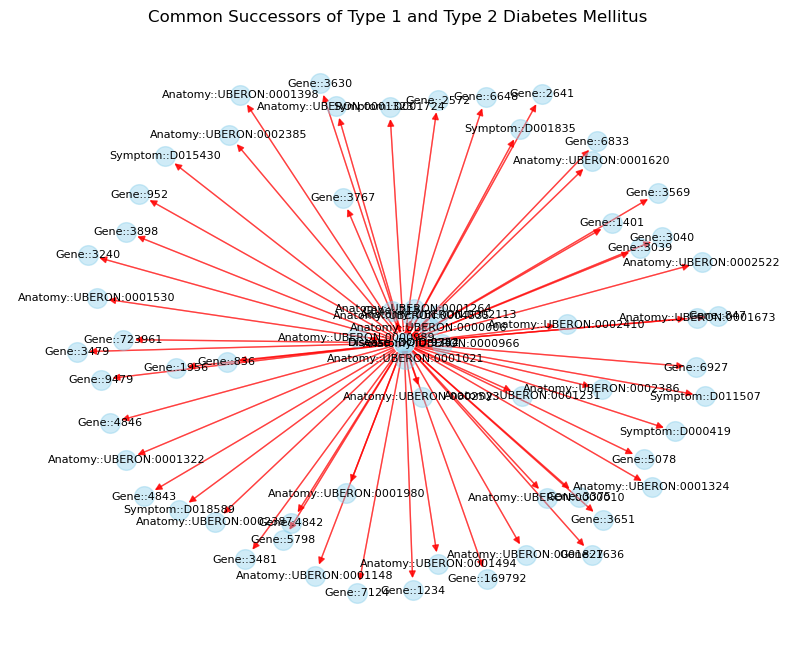

In [34]:
# Visualizing the common successors
import matplotlib.pyplot as plt

csucc_subgraph_nodes = common_successors | {type1_doid, type2_doid}
csucc_subgraph = G.subgraph(csucc_subgraph_nodes)

# Plotting
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(csucc_subgraph)  # positions for all nodes

# Nodes
nx.draw_networkx_nodes(csucc_subgraph, pos, node_size=200, node_color='skyblue', alpha=0.4)

# Edges, focusing on those from the disease nodes to the common successors
edges = [(n1, n2) for n1, n2 in csucc_subgraph.edges() if n1 in [type1_doid, type2_doid]]
nx.draw_networkx_edges(csucc_subgraph, pos, edgelist=edges, width=1.0, alpha=0.5, edge_color="red")

# Labels
nx.draw_networkx_labels(csucc_subgraph, pos, font_size=8, font_family='sans-serif')

plt.title('Common Successors of Type 1 and Type 2 Diabetes Mellitus')
plt.axis('off')  
plt.show()
# plt.savefig("networkplots/common_successors.png", dpi=300)  
plt.close()  

In [36]:
# Further analysis of the common successors - Fetching the names of the common symptoms

symptom_ids = {s for s in common_successors if s.startswith('Symptom::')}

# Fetching names for all common symptoms
symptom_names = {symptom_id: subG.nodes[symptom_id]['name'] for symptom_id in symptom_ids}
print("Symptom IDs and their Names:")
for symptom_id, name in symptom_names.items():
    print(f"{symptom_id}: {name}")

Symptom IDs and their Names:
Symptom::D000419: Albuminuria
Symptom::D011507: Proteinuria
Symptom::D018589: Gastroparesis
Symptom::D001835: Body Weight
Symptom::D015430: Weight Gain
Symptom::D001724: Birth Weight


> I.e. Low Birth Weight could be associated to an increased risk of diabetes mellitus

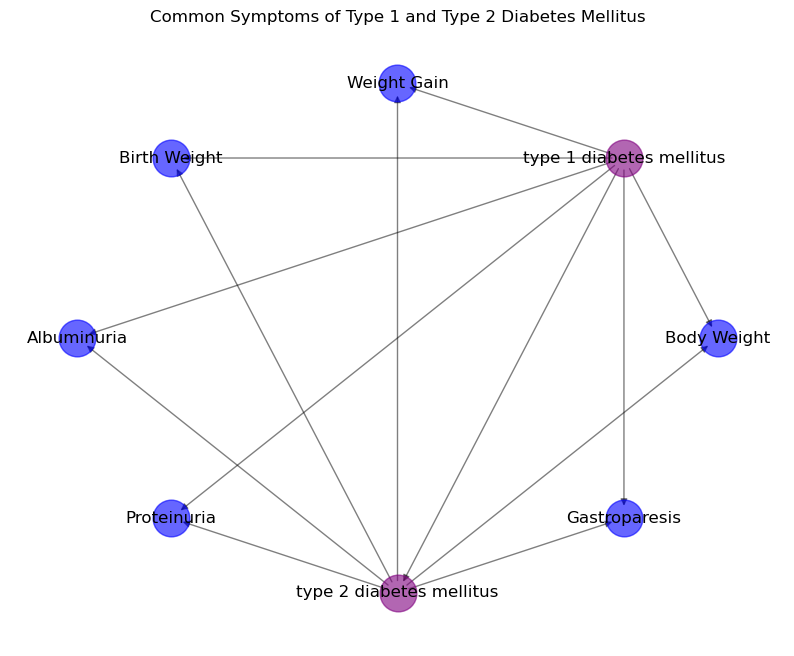

In [46]:
csymp_subgraph_nodes = symptom_ids | {'Disease::DOID:9744', 'Disease::DOID:9352'}
csymp_subgraph = G.subgraph(csymp_subgraph_nodes)

# Plotting
plt.figure(figsize=(10, 8))
pos = nx.shell_layout(csymp_subgraph)  # positions for all nodes

# Nodes, with specific colors for diseases and symptoms
nx.draw_networkx_nodes(csymp_subgraph, pos, nodelist=['Disease::DOID:9744', 'Disease::DOID:9352'], node_size=700, node_color='purple', alpha=0.6)
nx.draw_networkx_nodes(csymp_subgraph, pos, nodelist=list(symptom_ids), node_size=700, node_color='blue', alpha=0.6)

# Edges
nx.draw_networkx_edges(csymp_subgraph, pos,width=1.0, alpha=0.5)

# Labels with names
labels = {node: subG.nodes[node]['name'] for node in csymp_subgraph_nodes}
nx.draw_networkx_labels(csymp_subgraph, pos, labels=labels, font_size=12, font_family='sans-serif')

plt.title('Common Symptoms of Type 1 and Type 2 Diabetes Mellitus')
plt.axis('off') 
# plt.savefig("networkplots/common_symptoms.png", dpi=300)
plt.show()
plt.close()

In [12]:
# Needed for community detection
G_undirected = G.to_undirected(reciprocal=False, as_view=False)

In [13]:
import community as community_louvain


partition = community_louvain.best_partition(G_undirected)

# Finding the number of communities
num_communities = len(set(partition.values()))
print(f"Number of communities: {num_communities}")
community_sizes = {}
for community in set(partition.values()):
    community_sizes[community] = list(partition.values()).count(community)

# counting the number of communities with exactly one member
single_member_communities = sum(1 for size in community_sizes.values() if size == 1)

# Print the number of communities with exactly one member
if single_member_communities > 0:
    print(f"There are {single_member_communities} communities composed by 1 member.")

# Print the size of communities with more than one member
print("Size of each community with more than one member:")
for community, size in community_sizes.items():
    if size > 1:
        print(f"Community {community}: {size}")

# community of Type 1 and Type 2 Diabetes
type1_community = partition.get('Disease::DOID:9744', 'Not found')
type2_community = partition.get('Disease::DOID:9352', 'Not found')

print(f"Type 1 Diabetes is in community: {type1_community}")
print(f"Type 2 Diabetes is in community: {type2_community}")




Number of communities: 1883
There are 1873 communities composed by 1 member.
Size of each community with more than one member:
Community 0: 441
Community 2: 8991
Community 5: 9593
Community 6: 2758
Community 7: 920
Community 11: 5317
Community 14: 3249
Community 20: 2207
Community 21: 4219
Community 27: 7463
Type 1 Diabetes is in community: 2
Type 2 Diabetes is in community: 2


In [53]:
# Creating a subgraph to compute sophisticated metrics

def extract_subgraph(graph, start_nodes, max_depth):
    subgraph = nx.MultiDiGraph()
    for start_node in start_nodes:
        # Performing BFS 
        edges = list(nx.bfs_edges(graph, source=start_node, depth_limit=max_depth))
        subgraph.add_edges_from(edges)
        subgraph.add_node(start_node)  # Ensuring start node is included
    return subgraph


type1_doid = 'Disease::DOID:9744'
type2_doid = 'Disease::DOID:9352'
start_nodes = [type1_doid, type2_doid]

# Extracting a subgraph with a maximum depth of 2
disease_subgraph = extract_subgraph(G, start_nodes, max_depth=2)

# Print the number of nodes and edges in the subgraph
print("Number of nodes in the subgraph:", disease_subgraph.number_of_nodes())
print("Number of edges in the subgraph:", disease_subgraph.number_of_edges())

Number of nodes in the subgraph: 25107
Number of edges in the subgraph: 41152


In [54]:
def adamic_adar_index(graph, node1, node2):
    common_successors = set(graph.successors(node1)).intersection(set(graph.successors(node2)))
    aa_index = sum(1 / np.log(len(list(graph.predecessors(w)))) for w in common_successors if graph.in_degree(w) > 1)
    return aa_index

# Calculate Adamic/Adar Index
aa_similarity = adamic_adar_index(disease_subgraph, type1_doid, type2_doid)
print(f"Adamic/Adar Similarity: {aa_similarity}")

Adamic/Adar Similarity: 93.77517765778263


##### Defining the similarity betweeen Eye Pain and Blindess 

In [55]:
def find_symptom_ids(graph, symptom_names):
    symptom_ids = {}
    
    for node, data in graph.nodes(data=True):

        if data.get('name') in symptom_names:
            
            symptom_ids[data['name']] = node
    
    return symptom_ids

symptom_names = ['Eye Pain', 'Blindness']

# Getting the IDs for the symptoms
symptom_ids = find_symptom_ids(subG, symptom_names)
print(symptom_ids)

{'Blindness': 'Symptom::D001766', 'Eye Pain': 'Symptom::D058447'}


In [56]:
def get_predecessors_successors(graph, symptom_ids):

    results = {}
    for symptom_name, symptom_id in symptom_ids.items():
    
        predecessors = list(graph.predecessors(symptom_id))
        successors = list(graph.successors(symptom_id))
        results[symptom_name] = {
            'predecessors': predecessors,
            'successors': successors
        }
    
    return results

symptom_names = ['Eye Pain', 'Blindness']
symptom_ids = find_symptom_ids(G, symptom_names)

# Getting the predecessors and successors for the symptoms
symptom_relations = get_predecessors_successors(G, symptom_ids)
print(symptom_relations)


{'Blindness': {'predecessors': ['Disease::DOID:9835', 'Disease::DOID:2377', 'Disease::DOID:1192', 'Disease::DOID:10871', 'Disease::DOID:9744', 'Disease::DOID:1024', 'Disease::DOID:635', 'Disease::DOID:1909', 'Disease::DOID:11934', 'Disease::DOID:1686', 'Disease::DOID:12361', 'Disease::DOID:3070', 'Disease::DOID:0060119', 'Disease::DOID:10941', 'Disease::DOID:1319', 'Disease::DOID:2174', 'Disease::DOID:2994', 'Disease::DOID:13241', 'Disease::DOID:3565', 'Disease::DOID:184'], 'successors': []}, 'Eye Pain': {'predecessors': ['Disease::DOID:1686', 'Disease::DOID:10871', 'Disease::DOID:9835', 'Disease::DOID:2174', 'Disease::DOID:184', 'Disease::DOID:2994', 'Disease::DOID:1909'], 'successors': []}}


In [57]:
def find_common_diseases(graph, symptom_ids):
    
    diseases_per_symptom = {}

    for symptom_name, symptom_id in symptom_ids.items():
        # Fetching predecessors and successors
        predecessors = set(graph.predecessors(symptom_id))
        successors = set(graph.successors(symptom_id))
        
        # Combining the predecessors and successors to get all related diseases
        related_diseases = predecessors.union(successors)

        # Filter nodes to include only those that are classified as diseases
        diseases_per_symptom[symptom_name] = {node for node in related_diseases if 'Disease' in node}

    # Find common diseases between the symptoms
    common_diseases = set.intersection(*diseases_per_symptom.values())
    
    return common_diseases


symptom_names = ['Eye Pain', 'Blindness']
symptom_ids = find_symptom_ids(G, symptom_names)

# Get the common diseases for the symptoms
common_diseases = find_common_diseases(G, symptom_ids)
print("Common Diseases for 'Eye Pain' and 'Blindness':", common_diseases)


Common Diseases for 'Eye Pain' and 'Blindness': {'Disease::DOID:1909', 'Disease::DOID:10871', 'Disease::DOID:2174', 'Disease::DOID:184', 'Disease::DOID:9835', 'Disease::DOID:1686', 'Disease::DOID:2994'}


In [58]:
# Visualizing the common diseases

def prepare_visualization_data(graph, symptom_ids):
    
    related_nodes = set(symptom_ids.values())  
    edges_to_draw = []
    diseases_per_symptom = {}

    for symptom_name, symptom_id in symptom_ids.items():

        connected_diseases = set(graph.predecessors(symptom_id)).union(set(graph.successors(symptom_id)))
        diseases_per_symptom[symptom_name] = connected_diseases
        related_nodes.update(connected_diseases)

       
        for disease in connected_diseases:
            if (disease, symptom_id) in graph.edges:
                edges_to_draw.append((disease, symptom_id))
            if (symptom_id, disease) in graph.edges:
                edges_to_draw.append((symptom_id, disease))

    # Identify common diseases
    common_diseases = set.intersection(*diseases_per_symptom.values())
    
    return related_nodes, edges_to_draw, common_diseases
related_nodes, edges_to_draw, common_diseases = prepare_visualization_data(G, symptom_ids)


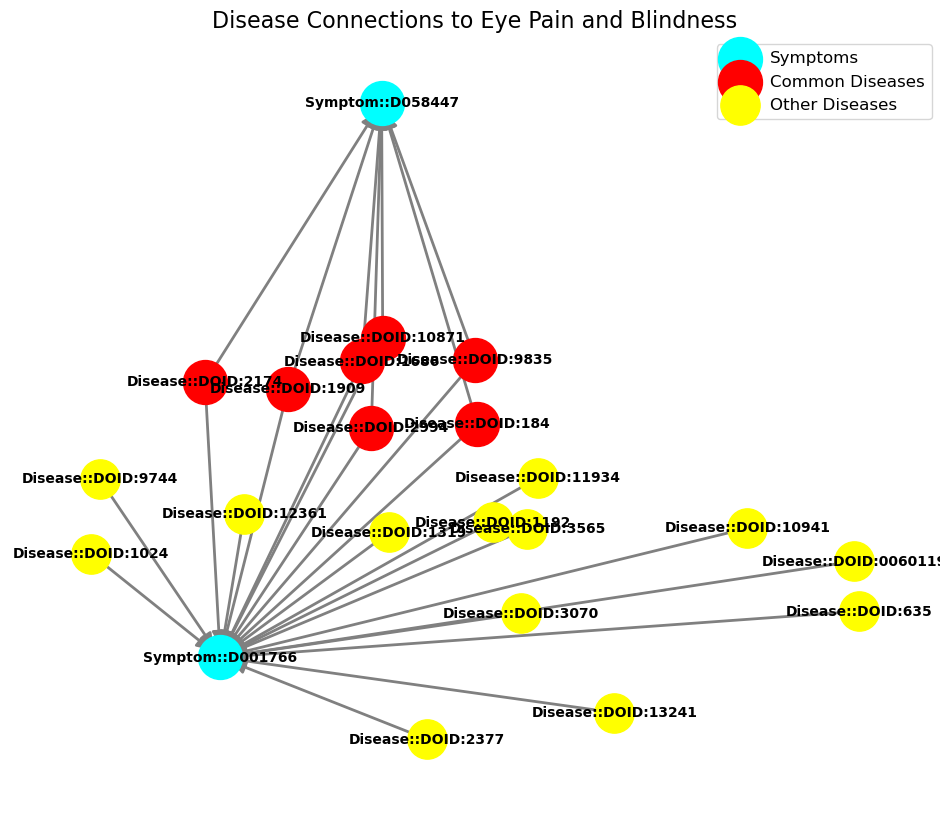

In [63]:

def visualize_disease_connections(graph, related_nodes, edges_to_draw, common_diseases, symptom_ids):
    
    subgraph = graph.subgraph(related_nodes)

   
    plt.figure(figsize=(12, 10))  
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50)  

    symptom_node_size = 1000
    disease_node_size = 800
    common_disease_node_size = 1000

    nx.draw_networkx_nodes(subgraph, pos, nodelist=symptom_ids.values(), node_color='cyan', label='Symptoms', node_size=symptom_node_size)
    nx.draw_networkx_nodes(subgraph, pos, nodelist=common_diseases, node_color='red', label='Common Diseases', node_size=common_disease_node_size)
    other_diseases = related_nodes - common_diseases - set(symptom_ids.values())
    nx.draw_networkx_nodes(subgraph, pos, nodelist=other_diseases, node_color='yellow', label='Other Diseases', node_size=disease_node_size)
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges_to_draw, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=2)
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')
    plt.title('Disease Connections to Eye Pain and Blindness', size=16)

    # Legend configuration
    plt.legend(scatterpoints=1, frameon=True, fontsize=12)

    plt.axis('off') 
    plt.show()
    # plt.savefig("networkplots/disease_connections.png", dpi=300)  
    plt.close()  

# Visualize the network
visualize_disease_connections(G, related_nodes, edges_to_draw, common_diseases, symptom_ids)

In [64]:
# function to get a random symptom
def patient(symptoms):
    symptom = random.choice(symptoms)
    print(f'Hello doctor, lately I have been showing {subG.nodes[symptom]["name"]}')
    print( """
    ( o o )
      ~    
     /|\\
    / | \\
     / \\
    /   \\
""")
    return symptom

In [65]:
# function to get diagnosis and cure based on symptom
def THEDOC(symptom):
    print('Well let\'s start the visit')
    print("""
   _____
  | o o |
  |  ~  | 
  |_____|  
   /|\\   
  / | \\   
   / \\   
  /   \\  
""")
    # compute diseases connected to symptom
    potential_diseases = {node for node in G.predecessors(symptom) if G.nodes[node]['kind'] == 'Disease'}
    # initialize set and dictionaries
    diseases_per_compound = defaultdict(int)
    side_effects_per_compound = defaultdict(set)
    disease_related_genes = set()
    compound_related_genes = defaultdict(set)

    print('You could have', *[subG.nodes[node]['name']  + ',' for node in potential_diseases], '\n')
    print('Let\'s find a cure, shall we?\n')

    # collect compounds and genes related to diseases
    for disease in potential_diseases:
        for compound in G.predecessors(disease):
            if G.nodes[compound]['kind'] == 'Compound':
                diseases_per_compound[compound] += 1
        for gene in G.successors(disease):
            if G.nodes[gene]['kind'] == 'Gene':
                disease_related_genes.add(gene)

    print('We could use', *[G.nodes[node]['name'] + ',' for node in diseases_per_compound], '\n')
    print('Mmm... Let me think...\n')

    # collect side effects and genes related to compounds
    for compound in diseases_per_compound:
        side_effects = {n for n in G.successors(compound) if G.nodes[n]['kind'] == 'Side Effect'}
        side_effects_per_compound[compound] = side_effects
        for gene in G.successors(compound):
            if G.nodes[gene]['kind'] == 'Gene':
                compound_related_genes[compound].add(gene)


    # normalize data
    data = np.array([
        list(diseases_per_compound.values()),  # Diseases treated
        list(map(lambda x: len(x), side_effects_per_compound.values())),  # Side effects
        [len(compound_related_genes[c].intersection(disease_related_genes)) for c in diseases_per_compound]  # Gene overlaps
    ]).T  # Transpose to fit the scaler input shape

    scaler = RobustScaler()
    normalized_data = scaler.fit_transform(data)

    # score each compound based on normalized values
    weights = [2, -1, 1] # weights for each feature with more focus on treated diseases
    compound_scores = {}
    for idx, compound in enumerate(diseases_per_compound):
        score = np.dot(normalized_data[idx], weights)  # dot product to calculate the score
        compound_scores[compound] = score

    # select the best compound based on the score
    best_compound = max(compound_scores, key=compound_scores.get)

    print('For this case the best option is', G.nodes[best_compound]["name"] + '. The possible side effects are', *[G.nodes[node]["name"] + ',' for node in side_effects_per_compound[best_compound]], '\n')
    print(f'I will see you again in {random.randint(2, 6)} weeks ;). \n')

    # construct the patient subgraph
    nodes_to_include = set(potential_diseases) | {best_compound, symptom} | side_effects_per_compound[best_compound] | (compound_related_genes[best_compound].intersection(disease_related_genes))
    patient_subG = G.subgraph(nodes_to_include)
    pos = nx.spring_layout(patient_subG)

    # set color for each node kind
    color_map = []
    for node in nodes_to_include:
        if node in potential_diseases:
            color_map.append('red')  # color for diseases
        elif node in side_effects_per_compound[best_compound]:
            color_map.append('yellow')    # color for side effects
        elif node == best_compound:
            color_map.append('green')   # color for the selected compound
        elif node in compound_related_genes[best_compound].intersection(disease_related_genes):
            color_map.append('purple') # color for genes
        else:
            color_map.append('blue')   # color for symptom

    # draw subgraph
    nx.draw(patient_subG, pos, with_labels=True, node_color=color_map, edge_color='gray', node_size=500, font_size=8)
    plt.title(f'Treatment Map for {subG.nodes[symptom]["name"]}')
    plt.show()

    # return selected compound infos
    return {
        'best_compound': best_compound,
        'compound_info': {
            'name': G.nodes[best_compound]['name'],
            'diseases_treated': diseases_per_compound[best_compound],
            'side_effects': len(side_effects_per_compound[best_compound]),
            'genes_overlap': len(compound_related_genes[best_compound].intersection(disease_related_genes)),
            'score': compound_scores[best_compound],
            'diseases': potential_diseases
        }
    }

>THEDOC function, given any symptom, yields the best compound to treat the possible diseases. Starting from the given symptom, it iterates the node's connected nodes. It computes the connected diseases, then for each diseases it computes the genes and compounds connected to each disease. After that, for each compound it computes the connected side effects and genes. In order to rank the possible compounds the function takes advantage of a weighted formula using 3 variables. The formula puts more focus on the number of treated diseases in order to maximize the probability of effectiveness. The variables for each compound are: number of connected diseases, number of connected side effects and number of connected genes in common with the genes connected to the possible diseases. The function normalizes each variable using RobustScaler, chosen because of its ability to handle outliers and variables which span a vast range (number of side effects). Finally, it applies the formula on each compound and ranks them, outputting the one with the highest score.


Hello doctor, lately I have been showing Mental Fatigue

    ( o o )
      ~    
     /|\
    / | \
     / \
    /   \

Well let's start the visit

   _____
  | o o |
  |  ~  | 
  |_____|  
   /|\   
  / | \   
   / \   
  /   \  

You could have breast cancer, primary biliary cirrhosis, multiple sclerosis, endogenous depression, 

Let's find a cure, shall we?

We could use Chlorambucil, Mitoxantrone, Capecitabine, Methotrexate, Idarubicin, Gemcitabine, Carboplatin, Eribulin, Thiotepa, Lapatinib, Docetaxel, Letrozole, Fulvestrant, Fluoxymesterone, Toremifene, Fluorouracil, Vinorelbine, Tamoxifen, Melphalan, Anastrozole, Ixabepilone, Doxorubicin, Irinotecan, Exemestane, Goserelin, Paclitaxel, Vinblastine, Raloxifene, Epirubicin, Betamethasone, Ethinyl Estradiol, Prochlorperazine, Aprepitant, Megestrol acetate, Conjugated Estrogens, Testosterone, Methyltestosterone, Estradiol valerate/Dienogest, Dexamethasone, Testosterone Propionate, Medroxyprogesterone Acetate, Estrone, Estradiol, Urso

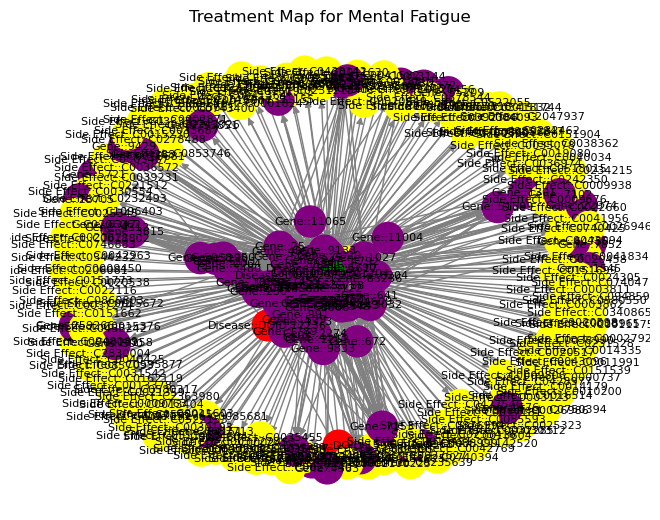

Medical Receipt:
Best compound: Mitoxantrone
Diseases treated: 2
Side effects: 177
Gene overlap: 87
Score: 6.757352941176471


In [66]:
# patient-doctor interaction
symptom = patient(symptom_nodes)
results = THEDOC(symptom)

print('Medical Receipt:')
print(f"Best compound: {results['compound_info']['name']}")
print(f"Diseases treated: {results['compound_info']['diseases_treated']}")
print(f"Side effects: {results['compound_info']['side_effects']}")
print(f"Gene overlap: {results['compound_info']['genes_overlap']}")
print(f"Score: {results['compound_info']['score']}")